<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;"><b>Treball de Final de Màster </b></p>
<p style="margin: 0; text-align:right;"><b>ANÀLISI DEL DIA MUNDIAL DE LES MALALTIES MINORITÀRIES (Font de dades: TWITTER)</b>.</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Disseny i Implementació del TFM.

# ANÀLISI
<p style="color:#0000FF">
En aquest Jupyter Notebook, s'apliquen tècniques d'aprenentatge no supervisat i s'estudia l'algorisme DBSCAN.
</p>

In [8]:
#llibreria numpy per usar la funció min().
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Accés a la funció KMeans del mòdul cluster de la llibreria Skicit-learn.
from sklearn.cluster import KMeans, DBSCAN
# Visualització gràfica de matplotlib per Python.
import matplotlib.pyplot as plt
# Per el càlcul de durada dels processos.
import time
import delayedsparse
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from itertools import cycle, islice

In [9]:
# Llegir el dataset
tuits = pd.read_excel("c:/users/qdeda/TFM_Code/DMMM_dataset_Final.xlsx")

In [10]:
tuits.head(1)

,_id,created_at,text_x,text_net,text_Norm,diaSem,dia,mes,yy,hora,...,user_idstr,user_friends_c,user_followers_c,user_listed_c,retweet_count,lang,polarity,subjectivity,emojis,text_y
0,5e78e80f4e54db2148d19749,Thu Feb 13 09:58:19 +0000 2020,RT @FEDER_ONG: Las 29 obras ganadoras del conc...,winning works photographic contest form travel...,win work photograph contest form travel exhibi...,Thursday,13,2,2020,9,...,4054806561,8,3,0,0,es,0.5,0.75,[],RT @FEDER_ONG: The 29 winning works of the pho...


In [11]:
tfidf_vect = TfidfVectorizer()
matriu_tfidf = tfidf_vect.fit_transform(tuits.text_net)

In [12]:
matriu_tfidf.shape

(98433, 21559)

## DBSCAN

In [13]:
# Visualitzacio amb PCA
Xz = matriu_tfidf
pca=delayedsparse.PCA(n_components=2)
X_PCA = pca.fit(Xz).transform(Xz)

In [14]:
time_start = time.time()
neigh = NearestNeighbors(n_neighbors=2)
X=X_PCA
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
temps=(time.time()-time_start)/60
print("#Distància per K-NN:",np.shape(X_PCA),"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
      int((temps-int(temps))*60),"segons.")

#Distància per K-NN: (98433, 2) 
 Durada:  0 minut/s  0 segons.


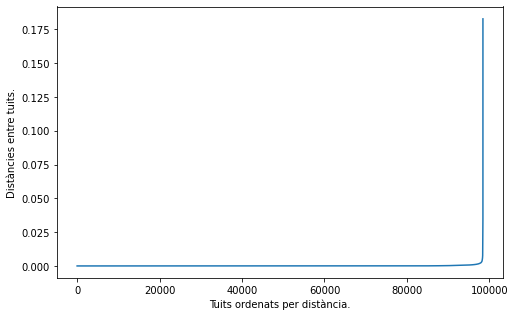

In [15]:
plt.figure(figsize=(8,5))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel("Tuits ordenats per distància.")
plt.ylabel("Distàncies entre tuits.")
plt.plot(distances)


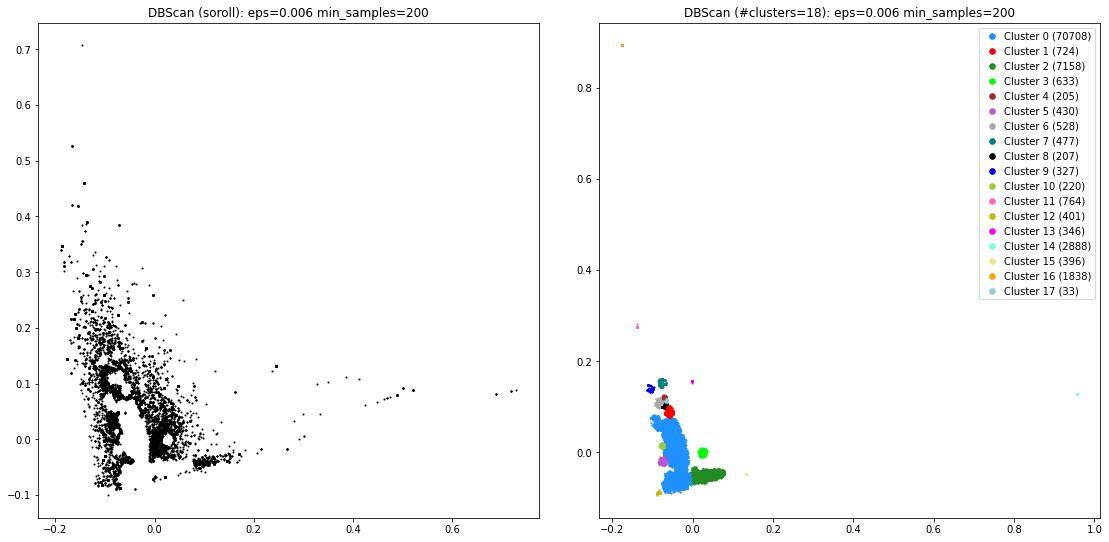

In [152]:
eps=0.006;  min_spl=200;
db = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      int(len(set(db.labels_))))))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(db.labels_==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
plt.savefig("glb-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

In [153]:
def tokens_mes_propers(model, vectorizer, mat_vect, topk=10):
    """
    Representació text dels primers-k mots
    més propers al seu centroide

    model: model de sklearn escollit.
    vectorizer: tipus de vectorització (tfidf)
    topk: nombre de paraules k seleccionades per cluster

    """
    # Podem usar diferents models
    nom_model = model.__class__.__name__
    paraules = vectorizer.get_feature_names()
    if nom_model is 'KMeans':
        grups=np.bincount(model.labels_)
        etq_rellevants = list(set(model.labels_))
        centroides = model.cluster_centers_.argsort()[:,::-1]
        for id_cluster in etq_rellevants:
            matching_rows = np.where(model.labels_ == id_cluster)[0]
            usuaris=[tuits.autor[tuits.index==u] for u in matching_rows]
            print('Cluster {} amb {} usuaris.'.format(id_cluster,grups[id_cluster]))
            for ind in centroides[id_cluster, :topk]:
                print(' {}'.format(paraules[ind]), end='')
            print()
    elif 'DBSCAN':
        # ignorem sorroll (-1)
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(model.labels_ == this_label)[0]
            coeff_sums = np.sum(mat_vect[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(paraules[idx]), end='')
            print()
    else:
        print('Tipus de model no implementat.')  

In [154]:
tokens_mes_propers(db,tfidf_vect,matriu_tfidf,15)

Cluster 0: rare diseases people disease day today world february know patients support million awareness thank tomorrow 
Cluster 1: day world today atlas produced mortality interactive wonder argentinians cu scientists every raise february find 
Cluster 2: us research rare together people join bo disease let across million care help around diseases 
Cluster 3: help donation bpan small could save morgan cure us please life today research visited germany 
Cluster 4: day today world initiation adding joined celebration professionals crecer february geographic loud hope statement institutional 
Cluster 5: rare refers diseases term weird name take today falling pr strong show time many worldwide 
Cluster 6: day today particular people world investiing visibility rare give february need support cancers important celebrated 
Cluster 7: day neu sickness nursing today called would little one tell like every calendar years february 
Cluster 8: day ro collaborative associations global february im